In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

In [2]:
path = 'data/kaari2132023.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

df = pd.read_csv(path, dtype=dtypes)

df['datetime'] = pd.to_datetime(df['datetime'])

## Delete the first and last 15 mins of each curve + elevation filter

In [3]:
MIN_ELEVATION = 20

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

df = df.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
df = df.loc[df['elm'] > MIN_ELEVATION]
df = df[(df['datetime'].dt.hour >= 6) & (df['datetime'].dt.hour < 18)]
df

C:\Users\virtanem\AppData\Local\Temp\ipykernel_14840\3006816350.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


,datetime,gps_site,sat_id,gdlatr,gdlonr,los_tec,tec,azm,elm,gdlat,glon,gnss_type,slant_f,vtec,pair_id,curve_id,filtered,blrmvd
295,2023-03-21 11:14:30,b'0ams',1,64.532524,19.349890,46.814060,21.145746,16.303226,20.094355,71.104233,25.366364,b'GLONASS ',2.171615,21.557252,GLONASS 0ams1,1,21.451800,0.105452
296,2023-03-21 11:15:00,b'0ams',1,64.532524,19.349890,46.654873,21.144844,16.089003,20.229473,71.084480,25.256243,b'GLONASS ',2.165320,21.546409,GLONASS 0ams1,1,21.448110,0.098299
297,2023-03-21 11:15:30,b'0ams',1,64.532524,19.349890,46.255600,21.093636,15.648898,20.477732,71.024033,25.009981,b'GLONASS ',2.153812,21.476151,GLONASS 0ams1,1,21.444276,0.031874
298,2023-03-21 11:16:30,b'0ams',1,64.532524,19.349890,46.067184,21.072393,15.427933,20.601658,71.004501,24.901131,b'GLONASS ',2.148096,21.445584,GLONASS 0ams1,1,21.439913,0.005671
299,2023-03-21 11:17:00,b'0ams',1,64.532524,19.349890,45.915043,21.067329,15.206366,20.725437,70.984787,24.792894,b'GLONASS ',2.142406,21.431531,GLONASS 0ams1,1,21.434872,-0.003342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6937615,2023-03-21 17:57:00,b'ylit',8,66.306602,23.667742,17.912926,15.768767,-123.329460,60.040695,65.323631,20.257374,b'GPS ',1.121287,15.975329,GPS ylit8,1,15.877838,0.097491
6937616,2023-03-21 17:57:30,b'ylit',8,66.306602,23.667742,17.878941,15.732742,-123.786652,59.996647,65.311333,20.272381,b'GPS ',1.121741,15.938569,GPS ylit8,1,15.874645,0.063925
6937617,2023-03-21 17:58:00,b'ylit',8,66.306602,23.667742,17.877129,15.717870,-124.696465,59.900913,65.286705,20.302183,b'GPS ',1.122731,15.922897,GPS ylit8,1,15.871145,0.051752
6937618,2023-03-21 17:59:00,b'ylit',8,66.306602,23.667742,17.863804,15.698978,-125.148911,59.849255,65.274376,20.316978,b'GPS ',1.123267,15.903428,GPS ylit8,1,15.867011,0.036417


## Creating the animation

### pierce points

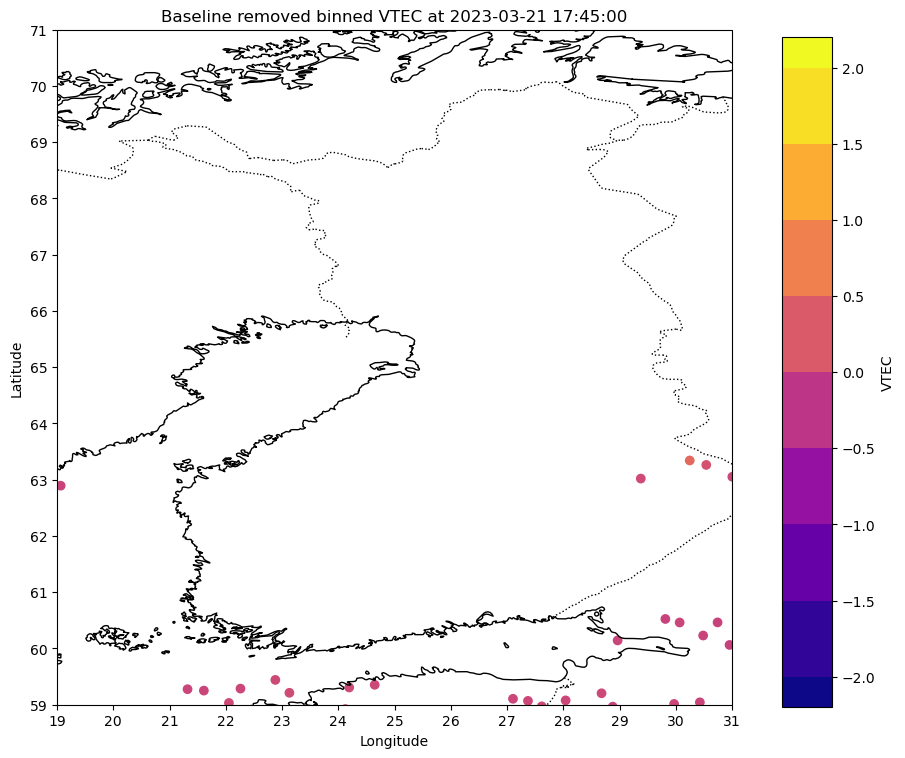

In [4]:
def create_fig_s(datetime, df):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime}')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array

frames = sorted(df['datetime'].unique())
create_fig_s(frames[1410], df)

### 2D histogram

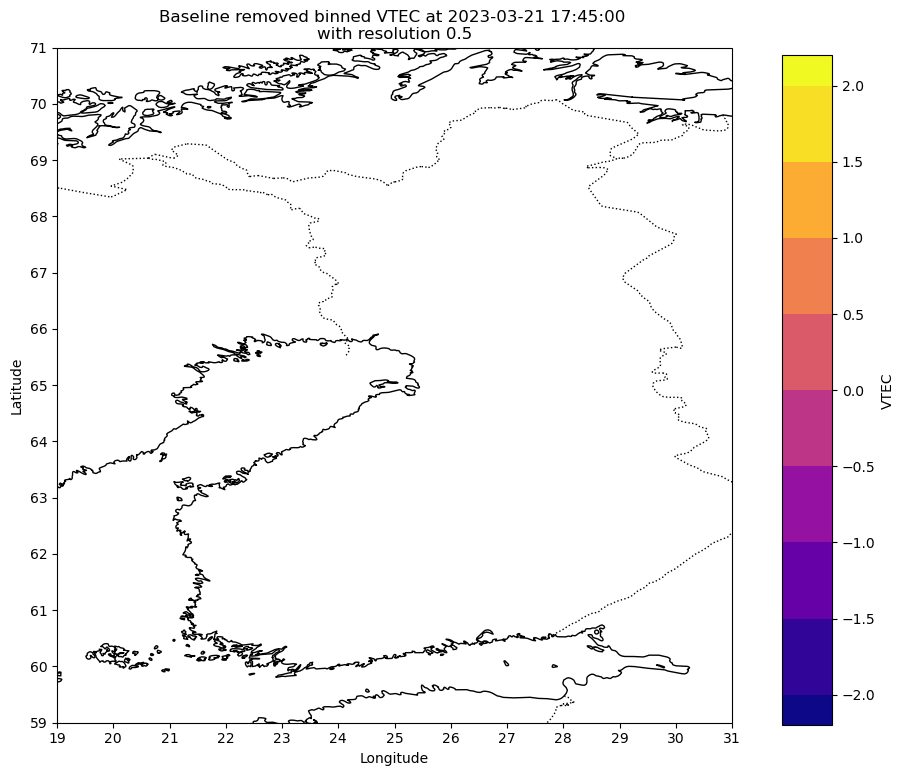

In [5]:
def create_fig_h(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(19, 32 + RES, RES), np.arange(59, 72 + RES, RES)]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                          levels=np.linspace(-2, 2, 9), extend='both', transform=ccrs.PlateCarree())
    # plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', edgecolors='k', 
    #             zorder=2, vmin=-2, vmax=2)  # Plot the original data points
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime} \nwith resolution {RES}')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array


frames = sorted(df['datetime'].unique())
create_fig_h(frames[1410], df)

### pcolormesh

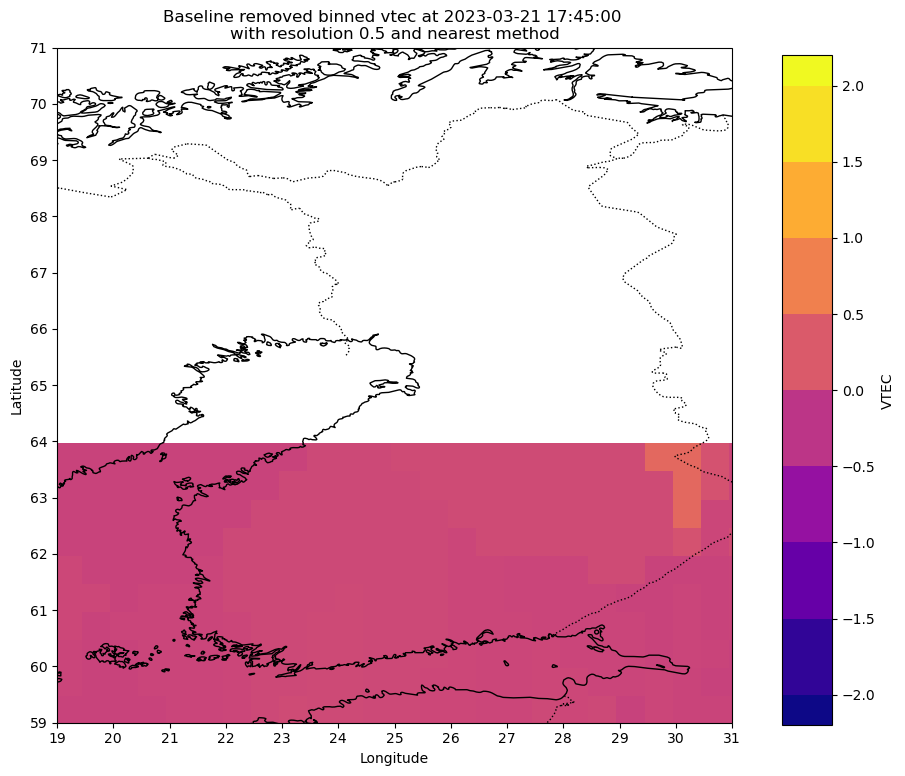

In [6]:
def create_fig_p(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + RES, RES)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + RES, RES)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method=METHOD)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = plt.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2.5,0.5), extend='both'
    )
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {datetime} \nwith resolution {RES} and {METHOD} method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array


frames = sorted(df['datetime'].unique())
create_fig_p(frames[1410], df)

### contourf

In [7]:
def create_fig(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + RES, RES)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + RES, RES)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method=METHOD)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, Z, cmap='plasma', vmin=-2, vmax=2, levels=np.linspace(-2, 2, 9), extend='both')

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {datetime} \nwith resolution {RES} and {METHOD} method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array

def update(frame):
    heatmap = create_fig(frame, df)
    plt.clf()
    plt.imshow(heatmap)

MovieWriter imagemagick unavailable; using Pillow instead.


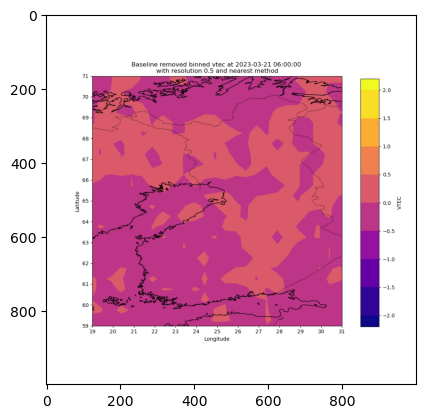

In [8]:
frames = sorted(df['datetime'].unique())
fig, ax = plt.subplots()

animation = FuncAnimation(fig, update, frames=frames, interval=100)

# Save the animation as a GIF file
animation.save('heatmap_animation.gif', writer='imagemagick')

# Save the animation as an MP4 file (requires ffmpeg or avconv installed)
# animation.save('animations/heatmap_animation_sg.mp4', writer='ffmpeg')